In [50]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [51]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [52]:
cd drive/My Drive/5001/IP1

[Errno 2] No such file or directory: 'drive/My Drive/5001/IP1'
/content/drive/My Drive/5001/IP1


In [53]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
import matplotlib.pyplot as plt


# from keras.optimizers import SGD
import tensorflow as tf


from sklearn.model_selection import train_test_split
from torch import nn

In [54]:
def preprocessing(filename):
  dataframe = pd.read_csv(filename)
  # print(dataframe)
  #fill na
  columns = dataframe.columns
  for i in range(1, len(columns)-1):
    dataframe[columns[i]].fillna((dataframe[columns[i]].mean()),inplace=True)
  
  scaler = MinMaxScaler()
  scaler.fit(dataframe)
  normalized_df = scaler.transform(dataframe)
  return np.array(normalized_df)

In [ ]:
train_np = preprocessing('./datasets/train.csv')

In [55]:
train_np = preprocessing('./datasets/train.csv')
test_np = preprocessing('./datasets/test.csv')
X_train = train_np[:,[1,2,3,4,5,6,7,8,9,11]]
y_train = train_np[:,-1]
X_test = test_np[:,[1,2,3,4,5,6,7,8,9,11]]

N,D = X_train.shape
print(N,D)

87 10


In [56]:
def visualize_performance(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [57]:
model = Sequential([
    Dense(4*D, input_shape=(D,)),
    # Dropout(.25, input_shape=(D,)),
    Activation('relu'),
    Dense(8*D, input_shape=(D,)),
    Dropout(.5, input_shape=(D,)),
    Activation('relu'),
    Dense(16*D, input_shape=(D,)),
    Dropout(.5, input_shape=(D,)),
    Activation('relu'),
    Dense(4*D, input_shape=(D,)),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 40)                440       
                                                                 
 activation_50 (Activation)  (None, 40)                0         
                                                                 
 dense_51 (Dense)            (None, 80)                3280      
                                                                 
 dropout_20 (Dropout)        (None, 80)                0         
                                                                 
 activation_51 (Activation)  (None, 80)                0         
                                                                 
 dense_52 (Dense)            (None, 160)               12960     
                                                                 
 dropout_21 (Dropout)        (None, 160)             

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


60/60 [==============================] - 1s 5ms/step - loss: 0.6735 - accuracy: 0.5667 - val_loss: 0.5937 - val_accuracy: 0.7037
Epoch 2/25
60/60 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6500 - val_loss: 0.5242 - val_accuracy: 0.7037
Epoch 3/25
60/60 [==============================] - 0s 3ms/step - loss: 0.5661 - accuracy: 0.6500 - val_loss: 0.4500 - val_accuracy: 0.7037
Epoch 4/25
60/60 [==============================] - 0s 3ms/step - loss: 0.5325 - accuracy: 0.7000 - val_loss: 0.3823 - val_accuracy: 0.8519
Epoch 5/25
60/60 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7833 - val_loss: 0.3245 - val_accuracy: 0.8889
Epoch 6/25
60/60 [==============================] - 0s 3ms/step - loss: 0.3966 - accuracy: 0.8500 - val_loss: 0.2647 - val_accuracy: 0.8889
Epoch 7/25
60/60 [==============================] - 0s 3ms/step - loss: 0.3870 - accuracy: 0.8500 - val_loss: 0.2195 - val_accuracy: 0.9259
Epoch 8/25
60/60 [=============

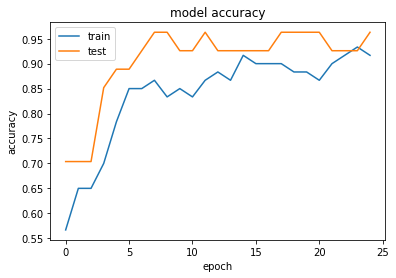

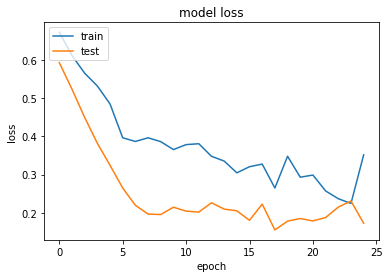

In [58]:
adam = tf.keras.optimizers.Adam(lr=1e-3)
RMSprop = tf.keras.optimizers.RMSprop(lr=1e-4, momentum=0.1)
# adagrad=tf.keras.optimizers.Adagrad(
#     learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07
# )
# SGD = tf.keras.optimizers.SGD(lr=1e-4)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, validation_split=0.3, batch_size=1)
visualize_performance(history)

In [59]:
def write_to_file(pred):
  final_output = pd.DataFrame(index=None, columns=['id','label'])
  output = ((pred>0.5)+0).reshape((59,))
  for i in range(59):
    final_output = final_output.append({'id': i, 'label' : output[i]}, ignore_index=True)
  final_output.to_csv('./submission_file.csv', index=False)

In [60]:
pred = model.predict(X_test, batch_size=10, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False)
write_to_file(pred)